<a href="https://colab.research.google.com/github/mmedlin1997/cifar10/blob/master/cifar10_torch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 19, 2020
v1 initial MNIST demo, both training and production 
v2 refactored training section into def
   added GPU support, runs on CPU, GPU if available
   benchmarks: training 4 epochs: CPU training 2m9s, GPU training 2m43s (GPU slower??) 
@author: mark

REF: https://www.youtube.com/watch?v=ixathu7U-LQ&t=17s
REF: https://www.cs.toronto.edu/~kriz/cifar.html

"""
#%% Import
#!pip install torch==1.4.0 torchvision==0.5.0  # downgrade pytorch from 1.6.0 because CUDA error: illegal memory access in Colab
import torch
import torchvision
from torchvision import datasets, transforms  # image data, transform to torch tensor format 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from datetime import timedelta

from platform import python_version
print("python", python_version())
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("matplotlib", matplotlib.__version__)
print("seaborn", sns.__version__)

python 3.6.9
torch 1.4.0
torchvision 0.5.0
matplotlib 3.2.2
seaborn 0.10.1


**torchvision.datasets** - common datasets (ex MNIST, COCO)

**ToTensor()** - A torchvision transform. Converts PIL Image or numpy.ndarray to tensor. Specifically, converts RGB or UINT8 (HxWxC) in range [0, 255] to torch.FloatTensor of shape (CxHxW) in the range [0.0, 1.0].

**Compose([])** - list of chained transforms

In [65]:
train = datasets.MNIST('', train=True, download=True, 
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))
test = datasets.MNIST('', train=False, download=True, 
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))
print(train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [66]:
# split training dataset into training and validation dataset (dict)
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, val_idx = train_test_split(list(range(len(train))), test_size=0.25)
datasets = {}
datasets['train'] = Subset(train, train_idx)
datasets['val'] = Subset(train, val_idx)

dataloaders = {x:torch.utils.data.DataLoader(datasets[x], 10, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

torch.Size([10, 1, 28, 28]) torch.Size([10])
{'train': 45000, 'val': 15000}


**torch.utils.data.DataLoader(dataset, batch_size (int, opt), shuffle (bool, opt))** - returns iterable over dataset. Can set batch size every epoch, and whether to shuffle every epoch. 

In [67]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [68]:
train_iter = iter(train_loader)                      # make iterable out of loader object

# verify dimensions of first batch (ex1: using iterable)
train_images, train_labels = train_iter.next()       # get next iteration
print("Image batch dimensions:", train_images.shape) # tensor size [batch_size, 1, h, w]
print("Image label dimensions:", train_labels.shape)

# verify dimensions of first batch (ex2: using loader in loop)
for train_images, train_labels in train_loader:
    print("Image batch dimensions:", train_images.shape)
    print("Image label dimensions:", train_labels.shape)
    break

Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])
Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])


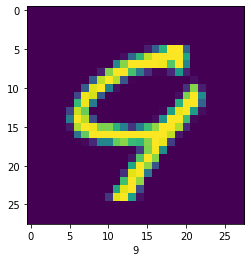

In [69]:
# show one image
index = 0
plt.imshow(train_images[index].view(28,28))
plt.xlabel(train_labels[index].item()) # labels are tensors, get value with item()
plt.show()

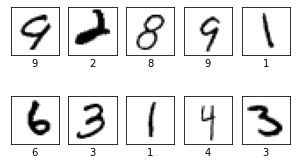

In [70]:


#%% Preview dataset
plt.figure(figsize=(5,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].view(28,28), cmap=plt.cm.binary) # reshape tensor(1,28,28) to matplotlib shape(28,28) 
    plt.xlabel(train_labels[i].item()) # labels are tensors, get value with item()
plt.show()

In [71]:
# choose GPU if available, else CPU
if torch.cuda.is_available() == True:
  count = torch.cuda.device_count()
  print("GPU number of devices:", count)
  print(*["GPU device["+str(x)+"]="+torch.cuda.get_device_name(x) for x in range(count)], sep="\n")
  print("GPU current device:", torch.cuda.current_device())

# device can be int or string
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

GPU number of devices: 1
GPU device[0]=Tesla K80
GPU current device: 0
cuda:0


Create a class to define the NN model.


In [72]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # Define layers
    self.fc1 = nn.Linear(28*28, 64) # Linear - fully-connected layer (input, output). This layer is input, designed to take a single image.
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 10)

  # Define how data flows forward through nn, and activations
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    logits = self.fc4(x)
    out = F.log_softmax(logits, dim=1)
    return out

model = Model().to(device)

# move model to GPU
#if torch.cuda.is_available():
#  model.cuda()

# verify model with single random image
#X = torch.randn((28,28))
#X = X.view(-1, 28*28)
#out = model(X)
#out

Train model

General function to train a model. Features: scheduling learning rate, save best model. Parameters:

* model - model
* criterion - loss function (ex. NLLLoss)
* optimizer - gradient descent optimizer
* scheduler - adjust optimizer learning rate from `torch.optim.lr_scheduler`
* epochs - (int) number of epochs


In [73]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
  start = timer()

  # init model state (save) and accuracy, in the end we return the best 
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
    
      # init batch loss
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        # move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # track history in train, not val
        torch.set_grad_enabled(phase == 'train')
        outputs = model(inputs.view(-1, 28*28))
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backpropagate and optimize in train, not val
        if phase == 'train':
          loss.backward()
          optimizer.step()
        
        # update batch statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      # step learning rate
      if phase == 'train':
        scheduler.step()

      # update epoch statistics
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
 
      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  
  # best statistics
  time_elapsed = timer() - start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model

In [74]:
import torch.optim as optim
from torch.optim import lr_scheduler 
import copy 

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.1)

train_model(model, criterion, optimizer, scheduler, epochs=5)

Epoch 0/4
----------
train Loss: 0.2966 Acc: 0.9080
val Loss: 0.1734 Acc: 0.9473

Epoch 1/4
----------
train Loss: 0.1330 Acc: 0.9592
val Loss: 0.1393 Acc: 0.9587

Epoch 2/4
----------
train Loss: 0.0984 Acc: 0.9685
val Loss: 0.1546 Acc: 0.9521

Epoch 3/4
----------
train Loss: 0.0798 Acc: 0.9754
val Loss: 0.1204 Acc: 0.9657

Epoch 4/4
----------
train Loss: 0.0679 Acc: 0.9785
val Loss: 0.1137 Acc: 0.9678

Training complete in 2m 43s
Best val Acc: 0.967800


Model(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [75]:
import torch.optim as optim

# optimizer_name(specify unfrozen weights, learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 0
losses, times = [], []
for epoch in range(epochs):
  start = timer() 
  for train_images, train_labels in train_loader:   # data is a batch of images and labels           
    model.zero_grad()                               # reset gradients instead summing of every backpropagation
    output = model(train_images.view(-1, 28*28))    # pass (batch) images thru model
    loss = F.nll_loss(output, train_labels)         # loss function
    loss.backward()                                 # backpropagate
    optimizer.step()                                # optimizer step toward global minimum
  end = timer()
  time = timedelta(seconds=end-start)
  losses.append(loss)
  times.append(time)
  print('epoch:', epoch, 'loss:', loss.item(), 'time:', time)
print(losses, times)

[] []


Test model

In [76]:
correct, total = 0, 0
print(device)
with torch.no_grad():      # do not allocate memory for gradient calculations on model 
    for inputs, labels in test_loader:
        # move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model(inputs.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(idx, i, torch.argmax(i), y[idx])
            if torch.argmax(i) == labels[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

cuda:0
Accuracy:  0.971


Save model as PyTorch

In [77]:
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Load model as PyTorch

In [78]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(checkpoint.keys())
print(checkpoint['model_state_dict'].keys())
print(checkpoint['optimizer_state_dict'].keys())

dict_keys(['model_state_dict', 'optimizer_state_dict'])
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
dict_keys(['state', 'param_groups'])


Results

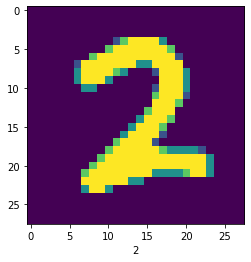

In [79]:
# Inspect one result
# NOTE: model is on GPU if avaiable, but CPU specified to matplotlib plots 
index = 5
expected = labels[index].cpu().item()
inferred = torch.argmax(model(inputs[index].view(-1,784))[0]).cpu().item()
plt.imshow(inputs[index].cpu().view(28,28))
plt.xlabel(inferred)
plt.show()

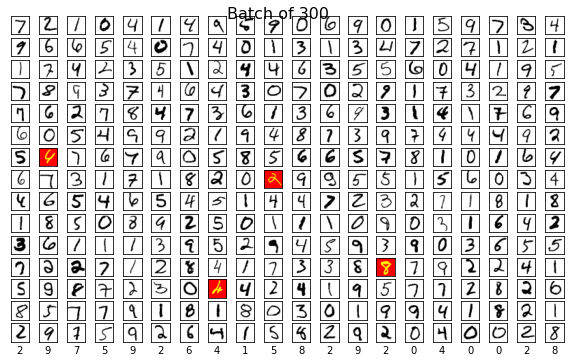

In [80]:
# Inspect batch
# NOTE: images predicted on GPU if available, then moved to CPU for matplotlib plot 
batch_size = 300
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
plt.figure(figsize=(10,6))
for test_images, test_labels in test_loader:
  output = model(test_images.to(device).view(-1,784)).cpu()  
  for i, img in enumerate(output):
    expected = test_labels[i]
    inferred = torch.argmax(img)
    cmap = plt.cm.binary if expected == inferred else plt.cm.autumn
    plt.subplot(batch_size/20, 20, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].view(28,28), cmap=cmap) 
    plt.xlabel(expected.item())
    plt.suptitle('Batch of ' + str(batch_size), fontsize=16, y=.9)
  break
plt.show()

Total test digits: 2064
Predicted distribution: tensor([209, 114, 253, 244, 215,  93, 211, 269, 192, 264])
Actual distribution: tensor([212, 111, 264, 242, 214, 124, 190, 260, 206, 241])


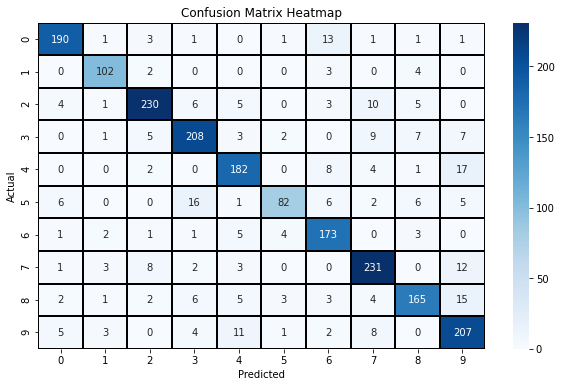

In [81]:
#%% Confusion Matrix
# Inspect batch
batch_size = 100
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

num_classes = 10
class_names = [i for i in range(10)]
cf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.uint8)

for test_images, test_labels in test_loader:
  output = model(test_images.to(device).view(-1,784)).cpu()  
  for i, img in enumerate(output):
    expected = test_labels[i]
    inferred = torch.argmax(img)
    cf_matrix[expected][inferred] += 1

plt.figure(figsize=(10,6))
ax = sns.heatmap(cf_matrix, annot=True, 
                 yticklabels=class_names, xticklabels=class_names, fmt='', 
                 linewidths=1, linecolor='k', cmap='Blues')
ax.set(title="Confusion Matrix Heatmap", xlabel="Predicted", ylabel="Actual",)

print('Total test digits:', cf_matrix.sum().item())
print('Predicted distribution:', cf_matrix.sum(0))
print('Actual distribution:', cf_matrix.sum(1))